<!-- Assignment 2 - WS 2023 -->

# Multilayer Perceptrons (21 points + 2 bonus)

This notebook contains the second assignment for the exercises in Deep Learning and Neural Nets 1.
It provides a skeleton, i.e. code with gaps, that will be filled out by you in different exercises.
All exercise descriptions are visually annotated by a vertical bar on the left and some extra indentation,
unless you already messed with your jupyter notebook configuration.
Any questions that are not part of the exercise statement do not need to be answered,
but should rather be interpreted as triggers to guide your thought process.

**Note**: The cells in the introductory part (before the first subtitle)
perform all necessary imports and provide utility function that should work without problems.
Please, do not alter this code or add extra import statements in your submission!

<span style="color:#d95c4c">**IMPORTANT:**</span> Please, change the name of your submission file so that it contains your student ID!

In this assignment, the goal is to get familiar with **Multi-Layer Perceptrons**. Essentially, MLPs are the result of stacking one or more of the simple networks from last time, interleaved with some form of non-linearities. This hints at some form of modular implementation, which will lead to the first building blocks of your very own deep learning library.

In [170]:
import numpy as np

from nnumpy import Module, Container, LossFunction
from nnumpy.testing import gradient_check
from nnumpy.utils import to_one_hot

rng = np.random.default_rng(1856)

## Module System

Multi-layer perceptrons can essentially be assembled from simple networks and activation functions. This kind of modularity is a recurring theme in deep learning, so much so that most deep learning frameworks are implemented in a modular fashion. This allows to construct complex networks from relatively simple building blocks. On top of that, it breaks down the possibly complex backprop derivation in more digestible pieces.

In order to kick-start your deep learning library, we provide you with the `Module` class, which implements some plumbing and python magic in an attempt to make them easier to use. In order for your models to inherit this functionality, they should be subclasses of `Module` and implement the functions `compute_outputs` and `compute_grads`. The first function should compute the result of the forward pass and collect the values that will be necessary to compute the gradients in the backward pass. The backward pass is to be implemented in the second function, which comes down to computing all possible gradients. The following schematic illustrates this idea.

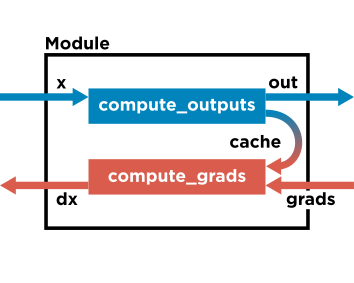

Concretely, `compute_outputs` takes one or more inputs and should return two values: the output of the module from the input and the `cache`, which contains the values necessary for the backward pass. `compute_grads` expects the gradients from the module that uses the outputs from this module as inputs, as well as the `cache` from the forward pass as inputs. This function should compute the gradients w.r.t. the module's parameters, but also the gradients w.r.t. inputs, which are to be returned by `compute_grads`. See the example module `Example` below.

In [171]:
class Example(Module):
    """ 
    Example of what a NNumpy module could look like.
    
    Examples
    --------
    This module can be used as follows:
    >>> module = Example()
    >>> x = np.random.randn(10)
    >>> pred = module.forward(x, x)
    >>> module.zero_grad()  # initialise gradients
    >>> dx, dx = module.backward(np.ones_like(pred))
    >>> print(module.scale.grad)
    """
    
    def __init__(self):
        # very important for automagic, always call super init!
        super().__init__()
        
        # add scalar parameter for fun
        self.scale = self.register_parameter('scale', 2.)
        
    def compute_outputs(self, s, t):
        """ 
        Compute outputs for this module.

        Parameters
        ----------
        input0, input1, ..., inputn : ndarray
            One or more inputs.

        Returns
        -------
        out : ndarray or tuple of ndarrays
            One or more module outputs.
        cache : ndarray or iterable of ndarrays
            One or more values that are necessary for the gradient computation.
        """
        # compute output value
        a = self.scale * s * t
        
        # collect info for backward pass
        cache = s, t
        
        return a, cache
    
    def compute_grads(self, grads, cache):
        """
        Compute gradients for this module.

        Parameters
        ----------
        grads : ndarray
            Gradients from subsequent module.
        cache : ndarray or iterable of ndarrays
            Cached values from the forward pass.

        Returns
        -------
        grad0, grad1, ..., gradn : ndarray
            Gradients w.r.t. to the input(s).

        Notes
        -----
        Updates the parameter gradients.
        """
        # collect info from forward pass
        s, t = cache
        
        # compute parameter gradient
        self.scale.grad = np.sum(s * t)
        
        # compute gradients w.r.t. inputs
        ds = grads * t
        dt = grads * s
        
        return ds, dt

### Exercise 1: Activation Function Module (6 Points)

Without non-linearities, Multi-Layer Perceptrons would make little sense. After all, multiple linear layers can always be reduced to a single-layer linear network, i.e. linear regression. Essentially any non-linear function could serve as activation function, but in practice only a few functions with specific properties are considered.

An example of a function that *could* be used as activation function, but is rarely found in practice, is the following algebraic formulation of a sigmoidal function:

$$\sigma_\mathrm{alg}(x) = \frac{x}{\sqrt{1 + x^2}}.$$

When plotted, this function looks very similar to the more commonly used $\tanh$.
Although it is not a commonly used activation function, there is no (obvious) reason why this shouldn't work.

Since most activation functions do not have any parameters, their modules are pretty straightforward to implement. Consider this first exercise as an opportunity to get familiar with the module system.

> Implement the forward and backward pass for the `Identity`, `Tanh` and `AlgebraicSigmoid` activation function modules.
> Use the formula above for the implementation of `AlgebraicSigmoid`.

In [172]:
class Identity(Module):
    """ NNumpy implementation of the identity function. """
        
    def compute_outputs(self, s):
        """
        Parameters
        ----------
        s : (N, K) ndarray
        
        Returns
        -------
        a : (N, K) ndarray
        cache : ndarray or iterable of ndarrays
        """
        a = s 
        cache = s 

        return a, cache
        raise NotImplementedError("TODO: implement Identity.compute_outputs method!")
    
    def compute_grads(self, grads, cache):
        """
        Parameters
        ----------
        grads : (N, K) ndarray
        cache : ndarray or iterable of ndarrays

        Returns
        -------
        ds : (N, K) ndarray
        """
        s = cache
        ds = grads

        return ds
        raise NotImplementedError("TODO: implement Identity.compute_grads method!")


class Tanh(Module):
    """ NNumpy implementation of the hyperbolic tangent function. """
        
    def compute_outputs(self, s):
        """
        Parameters
        ----------
        s : (N, K) ndarray
        
        Returns
        -------
        a : (N, K) ndarray
        cache : ndarray or iterable of ndarrays
        """
        a = np.tanh(s)
        cache = s 
        return a, cache

        raise NotImplementedError("TODO: implement Tanh.compute_outputs method!")
    
    def compute_grads(self, grads, cache):
        """
        Parameters
        ----------
        grads : (N, K) ndarray
        cache : ndarray or iterable of ndarrays

        Returns
        -------
        ds : (N, K) ndarray
        """
        s = cache
        d_tanh = 1 - np.tanh(cache)**2
        ds = grads * d_tanh
        return ds

        raise NotImplementedError("TODO: implement Tanh.compute_grads method!")

    
class AlgebraicSigmoid(Module):
    """ 
    NNumpy implementation of an algebraic sigmoid function.
    """

    def compute_outputs(self, s):
        """
        Parameters
        ----------
        s : (N, K) ndarray
        
        Returns
        -------
        a : (N, K) ndarray
        cache : ndarray or iterable of ndarrays
        """
        a = s/np.sqrt(1+s**2)
        cache = s 
        return a,s
        raise NotImplementedError("TODO: implement AlgebraicSigmoid.compute_outputs method!")

    def compute_grads(self, grads, cache):
        """
        Parameters
        ----------
        grads : (N, K) ndarray
        cache : ndarray or iterable of ndarrays

        Returns
        -------
        ds : (N, K) ndarray
        """
        s = cache
        ds = grads*(1/np.sqrt((1+s**2)**3))
        return ds
        raise NotImplementedError("TODO: implement AlgebraicSigmoid.compute_grads method!")

## Gradient Checking

It is not uncommon to make mistakes when computing gradients - or implementing them - in neural networks. In order to catch possible issues with the backward pass in deep learning, a technique called *gradient checking* is often used. To check the implementation of an analytically derived gradient, a numerical approximation is used to check the analytic gradient implementation against.

There are different methods to approximate gradients numerically, but one of the easiest is probably to use finite difference approximations. This method directly uses the definition of a derivative, 

$$f'(x) = \lim\limits{h \to 0} \frac{f(x + h) - f(x)}{h},$$

which can also be written as

$$f'(x) = \lim\limits{h \to 0} \frac{f(x) - f(x - h)}{h}$$

or, for the sake of symmetry, as the average of the two expressions above:

$$f'(x) = \lim\limits{h \to 0} \frac{f(x + h) - f(x - h)}{2h}.$$

In the end, a finite difference approximation is nothing more than one of the above formulas without limits, i.e. for some value of $h$. In practice, $h$ is set to some small value, often referred to as $\varepsilon$.

### Exercise 2: Gradient Checking (3 Points)
  
Although gradient checking normally does not appear in the interface of deep learning frameworks, it is an important tool to make sure implementations are correct. Therefore, we will start off by implementing a very simple gradient checker.

> Implement the `numeric_grad` function and use it to write a simple gradient checker (`my_gradient_check`) that is able to check the gradients of simple modules like the activation functions from the previous exercise.

**Hint:** Gradient checks for *element-wise* functions are considerably easier than gradient checks for multi-variable vector functions.

In [173]:
def numeric_grad(func, x, eps=1e-7):
    """
    Compute the numerical gradient for a(n element-wise) function.
    
    Parameters
    ----------
    func : callable
        The function to compute the difference quotient for.
    x : ndarray
        The points in which the gradient should be computed.
    eps : float, optional
        The epsilon perturbation used in the numerical computation.
        
    Returns
    -------
    grad : ndarray
        The numerically computed gradient.
    """
    grad = (func(x+eps)-func(x-eps))/(2*eps)
    return grad
    raise NotImplementedError("TODO: implement numeric_grad function!")

In [174]:
def my_gradient_check(module, x, eps=1e-7):
    """
    Check if the input gradients of an activation function module are correct.
    
    Parameters
    ----------
    module : Module
        The activation function module to check.
    x : ndarray
        The points in which the gradient should be computed.
    eps : float, optional
        The small perturbation used in the numerical computation.
        
    Returns
    -------
    success : bool
        Whether or not the gradient check passed.
    """
    return np.allclose(numeric_grad(module.forward,x,eps),module.backward(1))
    # Hint: use module.forward and module.backward to get the analytical gradients
    raise NotImplementedError("TODO: implement my_gradient_check function!")

In [175]:
class Square(Module):
    """ NNumpy module to show effectiveness of gradient checking. """
    
    def compute_outputs(self, x):
        return x * x, x
    
    def compute_grads(self, grads, x):
        return grads * 2 * x

    
square_check = my_gradient_check(Square(), np.linspace(-5, 5))
print("gradient check for Square:  ", "passed" if square_check else "failed")
id_check = my_gradient_check(Identity(), np.linspace(-3, 3))
print("gradient check for Identity:", "passed" if id_check else "failed")
tanh_check = my_gradient_check(Tanh(), np.linspace(-3, 3))
print("gradient check for Tanh:    ", "passed" if tanh_check else "failed")
tanh_check = my_gradient_check(AlgebraicSigmoid(), np.linspace(-3, 3))
print("gradient check for Sigmoid: ", "passed" if tanh_check else "failed")

gradient check for Square:   passed
gradient check for Identity: passed
gradient check for Tanh:     passed
gradient check for Sigmoid:  passed


## Fully Connected Layer

One of the key components in a multi-layer perceptron is the fully connected layer. It can be implemented in a fairly simple module with a weight matrix and bias vector as parameters. The `Module` base-class provides a method `Module.register_parameter(name, value)` that auto-magically creates an attribute `Module.<name>` for the module. This attribute has the type `Parameter`, which is essentiall a numpy array with an additional attribute `Parameter.grad` to store its gradients. In order to make sure that the parameters are correctly initialised, use the method `Module.reset_parameters()`. For initialising the gradients, there is also a method, `Module.zero_grad()`, that should be called after every update. Take the following code as an example:

In [176]:
m = Module()

# create attributes
m.register_parameter('theta', np.empty(3))

# parameter attribute (Note that parameters are uninitialised!)
print(m.theta, end=' ')
m.reset_parameters()  # initialise parameters
print(m.theta)

# parameter gradient attribute
print(m.theta.grad, end=' ')
m.zero_grad()
print(m.theta.grad)

[0. 0. 0.] [0. 0. 0.]
None [0. 0. 0.]


### Exercise 3: A Module with Parameters (6 Points)

Remember the linear regression from the first assignment? It's time to pour that code into a module and check whether you can correctly propagate gradients! 

> Implement the `Linear` module, which represents a fully connected layer. The derivatives w.r.t. the parameters can be stored in the `grad` attribute of registered parameters.

In [177]:
class Linear(Module):
    """
    NNumpy implementation of a fully connected layer.

    Attributes
    ----------
    in_features : int
        Number of input features (D) this layer expects.
    out_features : int
        Number of output features (K) this layer expects.
    use_bias : bool
        Flag to indicate whether the bias parameters are used.

    w : Parameter
        Weight matrix.
    b : Parameter 
        Bias vector.

    Examples
    --------
    >>> fc = Linear(10, 1)
    >>> fc.reset_parameters()  # init parameters
    >>> s = fc.forward(np.random.randn(1, 10))
    >>> fc.zero_grad()  # init parameter gradients
    >>> ds = fc.backward(np.ones_like(s))
    """
    
    def __init__(self, in_features, out_features, use_bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = use_bias
        
        self.w = self.register_parameter('w', np.empty((out_features,in_features))) 
        if use_bias:
            self.b = self.register_parameter('b',np.empty(out_features))
        # register parameters 'w' and 'b' here (mind use_bias!)
        # raise NotImplementedError("TODO: register parameters in Linear.__init__!")
        
        self.reset_parameters()
        
    def reset_parameters(self, seed: int = None):
        """ 
        Reset the parameters to some random values.
        
        Parameters
        ----------
        seed : int, optional
            Seed for random initialisation.
        """
        rng = np.random.default_rng(seed)
        self.w = rng.standard_normal(size=self.w.shape)
        if self.use_bias:
            self.b = np.zeros_like(self.b)
    
    def compute_outputs(self, x):
        """
        Parameters
        ----------
        x : (N, D) ndarray

        Returns
        -------
        s : (N, K) ndarray
        cache : ndarray or iterable of ndarrays
        """
        s = np.dot(x,self.w.T) + self.b
        cache = x
        return s,cache
        raise NotImplementedError("TODO: implement Linear.compute_outputs method!")
    
    def compute_grads(self, grads, cache):
        """
        Parameters
        ----------
        grads : (N, K) ndarray
        cache : ndarray or iterable of ndarrays

        Returns
        -------
        dx : (N, D) ndarray
        """
        self.w.grad = np.dot(grads.T,cache)
        if self.use_bias:
            self.b.grad = np.sum(grads,0)
        dx = np.dot(grads,self.w)
        return dx
        
        raise NotImplementedError("TODO: implement Linear.compute_grads method!")

In [178]:
# sanity check
linear = Linear(19, 7)
linear_check = gradient_check(linear, rng.standard_normal(size=(100, 19)), debug=True)
print("gradient check for Linear:", "passed" if linear_check else "failed")

gradient check for Linear: passed


## Multi-Layer Perceptron

A multi-layer perceptron is essentially a stack of single-layer networks with some sort of non-linearity. With the `Linear` module and activation function modules, we have all ingredients to construct MLPs and make learning *deep*.

### Exercise 4: Chaining modules (3 Points)

In essence, MLPs can be constructed by chaining the modules in the right order. Since this is a common pattern in deep learning architectures, it makes sense to make a general module for chaining other modules. 

> Implement forward and backward pass for the `Sequential` module so that it comes down to chaining all its sub-modules.
> Make sure that your implementation does not have any side-effects &mdash; i.e. your solution should **not** use `Module.forward` or `Module.backward`.

**Hint:** the cache will probably not be a single numpy array.

In [179]:
class Sequential(Container):
    """
    NNumpy module that chains together multiple one-to-one sub-modules.
    
    Examples
    --------
    Doubling a module could be done as follows:
    >>> module = Module()
    >>> seq = Sequential(module, module)
    
    Modules can be accessed by index or by iteration:
    >>> assert module is seq[0] and module is seq[1]
    >>> mod1, mod2 = (m for m in seq)
    >>> assert mod1 is module and mod2 is module
    """

    def __init__(self, *modules):
        super().__init__()
        if len(modules) == 1 and hasattr(modules[0], '__iter__'):
            modules = modules[0]
        
        for i, mod in enumerate(modules):
            self.add_module(mod)

    def compute_outputs(self, x):
        """
        Parameters
        ----------
        x : (N, D) ndarray

        Returns
        -------
        y : (N, K) ndarray
        cache : ndarray or iterable of ndarrays
        """
        caches = []
        last_output = x
        
        for module in self._modules:
            last_output, cache = module.compute_outputs(last_output)
            caches.append(cache)
        y = last_output
        return y,caches
        raise NotImplementedError("TODO: implement Sequential.compute_outputs method!")

    def compute_grads(self, grads, cache):
        """
        Parameters
        ----------
        grads : (N, K) ndarray
        cache : ndarray or iterable of ndarrays

        Returns
        -------
        dx : (N, D) ndarray
        """
        # curr_grad = grads
        # curr_cache = cache[-1]

        # for module in list(reversed(self._modules)):
        #     curr_grad = module.compute_grads(curr_grad,curr_cache)
        # dx = curr_grad
        sequential_grads = grads
        for mod, c in zip(reversed(self._modules), reversed(cache)):
            sequential_grads =  mod.compute_grads(sequential_grads, c)
        dx = sequential_grads
        return dx
        # Hint: you can access the list of modules through `self._modules`
        raise NotImplementedError("TODO: implement Sequential.compute_grads method!")

In [180]:
# example usage
class MLP(Sequential):
    """ NNumpy implementation of Multi-Layer Perceptron. """
    
    def __init__(self, *features, act_func=None, use_bias=True):
        """
        Parameters
        ----------
        f1, f2, ..., fn : int
            Number of neurons in each layer.
            f1 is the number of neurons in the input-layer.
            fn is the number of neurons in the output-layer.
        act_func : Module, optional
            Module to use as activation function.
            If not specified, the model is linear.
        use_bias : bool, optional
            Whether or not each layer should have a bias term.
        """
        super().__init__()
        self.in_features = features[0]
        self.out_features = features[-1]
        self.use_bias = use_bias
        self.phi = act_func or Identity()
        
        for n_in, n_out in zip(features[:-2], features[1:-1]):
            self.add_module(Linear(n_in, n_out, use_bias))
            self.add_module(self.phi)
        
        self.output_layer = Linear(features[-2], features[-1], use_bias)

In [181]:
# sanity check
mlp = MLP(19, 7, 11, 3, act_func=Tanh())
mlp_check = gradient_check(mlp, rng.standard_normal(size=(100, 19)), debug=True)
print("gradient check for MLP:", "passed" if mlp_check else "failed")

gradient check for MLP: passed


### Exercise 5: Necessity for Non-linearity (1 Point)

As already mentioned, a multi-layer perceptron without non-linearities is equivalent to a single-layer network. How is that?

> Set the weights for a single-layer perceptron so that it produces the same results as the given multi-layer perceptron.

In [182]:
# multi-layer perceptron
mlp = Sequential(
    Linear(23, 17),
    Linear(17, 19),
    Linear(19, 7)
)

# single-layer perceptron
slp = Linear(23, 7)
mlp_w = []
for n, p in mlp.named_parameters():
    if 'w' in n:
        mlp_w.append(np.array(p))
# mlp_w = [p for n, p in mlp.named_parameters() if 'w' in n]


w = mlp_w[0]

for i in mlp_w[1:]:
    w = w.T.dot(i.T)
    w = w.T


slp.w = w  # TODO: set weight value here
slp.b = 0  # TODO: set bias value here

# test equivalence
x = np.linspace(-3, 3, 23)

equivalence_check = np.allclose(slp.forward(x), mlp.forward(x))
print("Are non-linearities necessary?", "yes" if equivalence_check else "not for me...")

Are non-linearities necessary? yes


## Loss Function Modules

Also loss functions fit in the module system. Loss functions take two inputs and can normally be returned in one of three ways:

  1. An array of individual sample errors
  2. The total sample error(s)
  3. The average sample error(s)
  
To facilitate these three options, a `LossFunction` module has been provided. This module accepts a keyword argument `reduction` that allows to specify how to *reduce* the errors for different sampels (options are respectively `'none'`, `'sum'` or `'mean'`). For gradient checking, you want to use `'none'`, but in practice it is more common to use something like `'mean'`.

### Exercise 6: Logit Cross-Entropy (2 Points + 2 Bonus Points)

The last assignment required you to implement the `softmax` and `cross_entropy` functions separately. In most deep learning frameworks, these functions are merged into a single loss function. The main reason is numerical stability, but it also simplifies the computation of the gradients.

> Implement a module, i.e. forward and backward pass, that computes the cross-entropy from pre-activations and one-hot targets. E.g. by first computing softmax and then applying cross-entropy. Don't forget to compute the gradients w.r.t. targets! 

For the bonus point, you would have to

> implement the numerically stable solution.

In [183]:
class LogitCrossEntropy(LossFunction):
    """
    NNumpy implementation of the cross entropy loss function
    computed from the logits, i.e. before applying the softmax nonlinearity.
    """
    def softmax(self, s):
        return np.transpose(np.exp(s))/np.sum(np.exp(s), 1)

    def raw_outputs(self, logits, targets):
        """
        Computation of loss without reduction.

        Parameters
        ----------
        logits : (N, K) ndarray
        targets : (N, K) ndarray
        
        Returns
        -------
        cross_entropy : (N, 1) ndarray
        cache : ndarray or iterable of ndarrays
        """
        y = np.transpose(self.softmax(np.transpose(logits)))
        cache = y, targets
        cross_entropy = -np.sum(targets * np.log(np.transpose(y)), axis=1)
        
        return cross_entropy, cache

        raise NotImplementedError("TODO: implement LogitCrossEntropy.raw_outputs method!")

    def raw_grads(self, grads, cache):
        """
        Computation of gradients for loss without reduction.

        Parameters
        ----------
        grads : (N, 1) ndarray
        cache : ndarray or iterable of ndarrays

        Returns
        -------
        dlogits : (N, K) ndarray
        dtargets : (N, K) ndarray
        """
        y, targets = cache
        dtargets = grads.reshape(-1, 1) * -np.log(np.transpose(y))
        dlogits =  grads.reshape(-1, 1) * (np.transpose(y) - targets)
       
        return dlogits, dtargets

        raise NotImplementedError("TODO: implement LogitCrossEntropy.raw_grads method!")

In [184]:
# sanity check
lce = LogitCrossEntropy(reduction='none')
targets = to_one_hot(rng.integers(7, size=100))
lce_check = gradient_check(lce, rng.standard_normal(size=(100, 7)), targets, debug=True)
print("gradient check for LogitCrossEntropy:", "passed" if lce_check else "failed")

2.651651697626776 > 2e-06
dx numeric:  (array([[ 0.05182125, -0.86602688,  0.08021152,  1.70928519,  0.12624747,
         0.18801936,  0.09345626],
       [-0.87942374,  0.43339696,  0.12203432,  0.05969397,  0.13274291,
         0.03149793,  0.10704412],
       [ 0.00804522,  0.10279925,  0.47187615,  0.10002989,  0.32987765,
        -0.98035983,  0.01086067],
       [ 0.01425497,  0.1694975 , -0.59650591,  0.0449009 ,  0.43567394,
         0.25588366,  0.03230343],
       [ 0.03888641,  0.09528893,  0.12718181,  0.02642577, -0.83947137,
         0.15547306,  0.06082564],
       [ 0.09204237,  0.20167772,  0.15968365, -0.41485248,  0.09313251,
         0.01471409,  0.05931943],
       [ 0.62529116,  0.83512745, -0.28616503,  0.04532012,  0.10056837,
         0.08149408,  0.16633399],
       [ 0.02526144,  0.08507922,  0.09701708,  0.28636384,  0.09718931,
        -0.9541854 ,  0.13292242],
       [ 0.08552254,  0.20263531,  0.38157259, -0.87307993,  0.42641545,
         0.08593364,  0